#Comparison of logistic regression algorithms in Python versus Spark for linear kernel only 

##Linear separable example
+ **Gradient descent in Python**
+ **Gradient descent in Spark**

##Linearly inseparable example
+ **Same as for seperable data set**

#Data Generation for Linear Separable data

x1 and x2 are uniform distributed and the boundry of y is x1\*w[0]+x2\*w[1] + w[2].

In [41]:
import numpy as np
def data_generate(seperable=True):
    size = 100
    np.random.seed(0)
    x1 = np.random.uniform(-4,4,100)
    x2 = np.random.uniform(-4,4,100)
    coeff = [8,-3,2]
    b = coeff.pop()
    sd = sum([c*c for c in coeff])**0.5
    coeff.append(b)
    coeff = [c/sd for c in coeff]
    v = (x1*coeff[0]+x2*coeff[1] + coeff[2])
    y = (v>0)*2-1
    data = np.column_stack((x1,x2))
    idx = abs(v)>1
    data = data[idx,:]
    y = y[idx]
    if not seperable:
        wrongidx = np.random.choice(range(len(y)),6, replace =False )
        y[wrongidx] = -y[wrongidx]
    return data, y, coeff

In [42]:
data_sep, y_sep, w_sep = data_generate(seperable=True)

In [43]:
w_sep

[0.9363291775690445, -0.3511234415883917, 0.23408229439226114]

##Data Visualization

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_data_boundary(data, y, w, sep=True):
    cols = {1: 'r', -1: 'b'}
    for i in range(len(y)):
        plt.plot(data[i,0], data[i,1], cols[y[i]]+'o')
    plt.xlabel("x1")
    plt.ylabel("x2")
    if sep:
        plt.title('Linear Separable data: True boundary')
    else:
        plt.title('Linear Inseparable data: True boundary')
    x_b = [-4,4]
    y_b = [-(i*w[0]+w[2])/w[1]for i in x_b]
    plt.plot(x_b,y_b)
    plt.grid()
    plt.show()

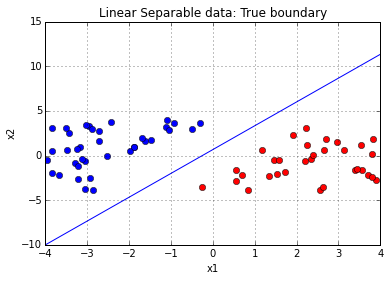

In [45]:
plot_data_boundary(data_sep, y_sep, w_sep)

##Python-Gradient Descent

Input:
+ data: Feature Information
+ y: label information
+ eta: learning rate
+ iter_num : maximum iteration number
+ regPara: regularization parameter
+ stopCriteria: stop criteria

Output:
+ w : coeffcients of boudary 

In [46]:
#gradient descent (and with NO stochasticity!)
# Objective Function
# minw   λ/2   w’w   +   1/m Σi log(1+exp(yi(w’xi – b)))   
# gradient 
#   -y*(1-1/(1+exp(yi(w’xi – b))))*x

def logisticReg_GD(data,y,w=None,eta=0.05,iter_num=500,regPara=0.01,stopCriteria=0.0001,reg="Ridge"):  
    data = np.append(data,np.ones((data.shape[0],1)),axis=1)
    if w is None:
        w = np.random.normal(size=data.shape[1])
    for i in range(iter_num):
        wxy = np.dot(data,w)*y
        g = np.dot(data.T,-y*(1-1/(1+np.exp(-wxy))))/data.shape[0] # Gradient of log loss'
        if reg == "Ridge":
            wreg = w*1
            wreg[-1] = 0 #last value of weight vector is bias term; ignore in regularization
        elif reg == "Lasso":
            wreg = w*1
            wreg[-1] = 0 #last value of weight vector is bias term; ignore in regularization
            wreg = (wreg>0).astype(int)*2-1
        else:
            wreg = np.zeros(w.shape[0])
        wdelta = eta*(g+regPara*wreg) #gradient: log loss + regularized term
        if sum(abs(wdelta))<=stopCriteria*sum(abs(w)): #Convergence condition
            break
        w = w - wdelta
    return w

###Ridge Logistic Regression

In [47]:
np.random.seed(400)
w_gd_sep_ridge = logisticReg_GD(data_sep,y_sep,reg="Ridge")
print w_gd_sep_ridge

[ 1.84106359 -0.63166074  0.00472968]


###Lasso Logistic Regression

In [48]:
np.random.seed(400)
w_gd_sep_lasso = logisticReg_GD(data_sep,y_sep,reg="Lasso")
print w_gd_sep_lasso

[ 1.90212754 -0.60763246  0.18656826]


###How does w converge for ridge regression?

In [49]:
def plot_iteration(data,y,w_true):
    plt.figure(figsize=(10,10))
    cols = {1: 'r', -1: 'b'}
    for i in range(len(y)):
        plt.plot(data[i,0], data[i,1], cols[y[i]]+'o')
    plt.xlabel("x1",fontsize=20)
    plt.ylabel("x2",fontsize=20)
    plt.title('Weights Convergence for Gradient Descent',fontsize=20)
    x_b = [-4,4]

    y_b = [-(i*w_true[0]+w_true[2])/w_true[1]for i in x_b]
    plt.plot(x_b,y_b,'r--',label = "True Boundary", linewidth=4.0)  

    np.random.seed(800)
    wgd = np.random.normal(size=data.shape[1]+1)
    y_b = [-(i*wgd[0]+wgd[2])/wgd[1] for i in x_b]
    plt.plot(x_b,y_b,color ='r',label = "0 Iterations")

    wgd = logisticReg_GD(data,y,wgd,iter_num=10)
    y_b = [-(i*wgd[0]+wgd[2])/wgd[1] for i in x_b]
    plt.plot(x_b,y_b,color ='g',label = "10 Iterations")

    wgd = logisticReg_GD(data,y,wgd,iter_num=10)
    y_b = [-(i*wgd[0]+wgd[2])/wgd[1] for i in x_b]
    plt.plot(x_b,y_b,color ='b',label = "20 Iterations")

    wgd = logisticReg_GD(data,y,wgd,iter_num=30)
    y_b = [-(i*wgd[0]+wgd[2])/wgd[1] for i in x_b]
    plt.plot(x_b,y_b,color ='y',label = "50 Iterations")

    wgd = logisticReg_GD(data,y,wgd,iter_num=50)
    y_b = [-(i*wgd[0]+wgd[2])/wgd[1] for i in x_b]
    plt.plot(x_b,y_b,color ='m',label = "100 Iterations")

    wgd = logisticReg_GD(data,y,wgd,iter_num=100)
    y_b = [-(i*wgd[0]+wgd[2])/wgd[1] for i in x_b]
    plt.plot(x_b,y_b,color ='c',label = "200 Iterations")

    wgd = logisticReg_GD(data,y,wgd,iter_num=300)
    y_b = [-(i*wgd[0]+wgd[2])/wgd[1] for i in x_b]
    plt.plot(x_b,y_b, 'c--',label = "500 Iterations", linewidth=4.0)
    

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20,borderaxespad=0.)
    plt.grid()
    plt.show()

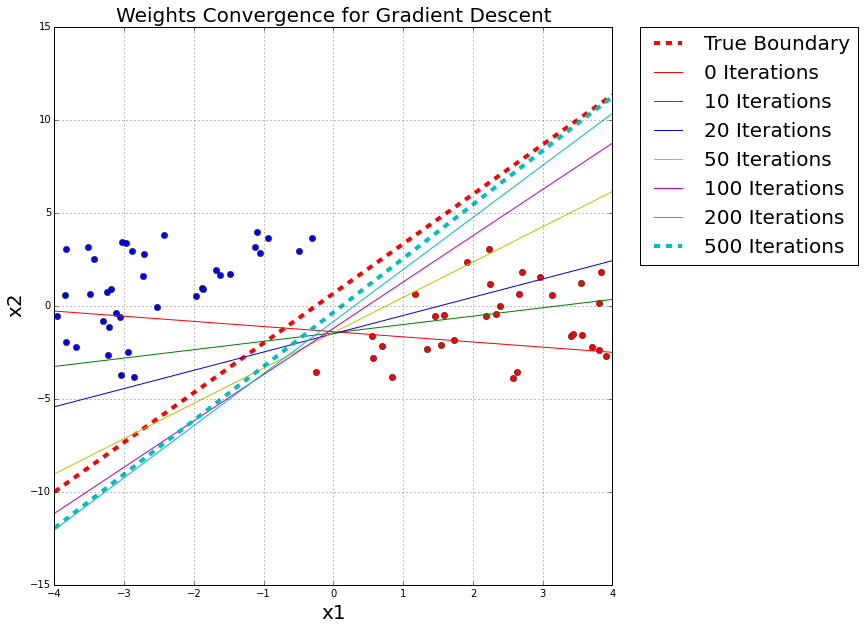

In [50]:
plot_iteration(data_sep,y_sep,w_sep)

##Spark-Gradient Descent

In [30]:
import os
import sys
spark_home = os.environ['SPARK_HOME'] = '/Users/liang/Downloads/spark-1.3.0-bin-hadoop2.4/'
if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.3.0
      /_/

Using Python version 2.7.10 (default, May 28 2015 17:04:42)
SparkContext available as sc, HiveContext available as sqlCtx.


In [51]:
#gradient descent (and with NO stochasticity!)
# Objective Function
# minw   λ/2   w’w   +   1/m Σi log(1+exp(yi(w’xi – b)))   
# gradient 
#   -y*(1-1/(1+exp(yi(w’xi – b))))*x

def logisticReg_GD_Spark(data,y,w=None,eta=0.05,iter_num=500,regPara=0.01,stopCriteria=0.0001,reg="Ridge"):
    #eta learning rate
    #regPara
    dataRDD = sc.parallelize(np.append(y[:,None],data,axis=1)).cache()
    if w is None:
        w = np.random.normal(size=data.shape[1]+1)
    for i in range(iter_num):
        w_broadcast = sc.broadcast(w)
        g = dataRDD.map(lambda x: -x[0]*(1-1/(1+np.exp(-x[0]*np.dot(w_broadcast.value,np.append(x[1:],1))))) \
                        *np.append(x[1:],1)).reduce(lambda x,y:x+y)/data.shape[0] # Gradient of logloss

        if reg == "Ridge":
            wreg = w*1
            wreg[-1] = 0 #last value of weight vector is bias term; ignore in regularization
        elif reg == "Lasso":
            wreg = w*1
            wreg[-1] = 0 #last value of weight vector is bias term; ignore in regularization
            wreg = (wreg>0).astype(int)*2-1
        else:
            wreg = np.zeros(w.shape[0])
        wdelta = eta*(g+regPara*wreg)  #gradient: hinge loss + regularized term 
        if sum(abs(wdelta))<=stopCriteria*sum(abs(w)): # converged as updates to weight vector are small
            break
        w = w - wdelta
    return w

###Ridge Logistic Rigression

In [52]:
np.random.seed(400)
w_gd_spark_sep_ridge = logisticReg_GD_Spark(data_sep,y_sep,reg="Ridge")
print w_gd_spark_sep_ridge

[ 1.84106359 -0.63166074  0.00472968]


###Lasso Logistic Rigression

In [53]:
np.random.seed(400)
w_gd_spark_sep_lasso = logisticReg_GD_Spark(data_sep,y_sep,reg="Lasso")
print w_gd_spark_sep_lasso

[ 1.90212754 -0.60763246  0.18656826]


###Comparison

In [54]:
def comparison_plot(data,y,w,w_ridge,w_lasso,sep=True):
    plt.figure(figsize=(10,10))
    cols = {1: 'r', -1: 'b'}
    for i in range(len(y)):
        plt.plot(data[i,0], data[i,1], cols[y[i]]+'o')
    plt.xlabel("x1",fontsize=20)
    plt.ylabel("x2",fontsize=20)
    if sep:
        plt.title('Comparison for linearly separable data',fontsize=20)
    else:
        plt.title('Comparison for linearly inseparable data',fontsize=20)
    x_b = [-4,4]

    y_b = [-(i*w[0]+w[2])/w[1]for i in x_b]
    plt.plot(x_b,y_b,'b--',label = "True Boundary", linewidth=4.0)  

    y_b = [-(i*w_ridge[0]+w_ridge[2])/w_ridge[1]for i in x_b]
    plt.plot(x_b,y_b,'r--',label = "Ridge", linewidth=4.0) 

    y_b = [-(i*w_lasso[0]+w_lasso[2])/w_lasso[1]for i in x_b]
    plt.plot(x_b,y_b,'r',label = "Lasso", )

    #y_b = [-(i*w_sklearn_1[0]+w_sklearn_1[2])/w_sklearn_1[1]for i in x_b]
    #plt.plot(x_b,y_b,'m',label = "SK-learner-Primal-SGD") 

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2,fontsize=20, borderaxespad=0.)
    plt.grid()
    plt.show()

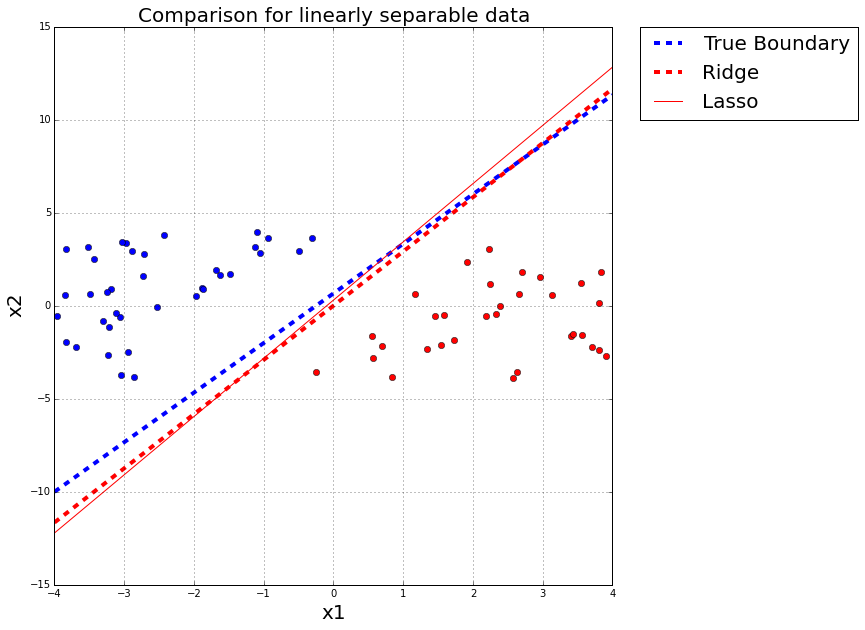

In [55]:
comparison_plot(data_sep,y_sep,w_sep,w_gd_spark_sep_ridge,w_gd_spark_sep_lasso)

##Data Generation for linear inseparable data

In [33]:
data_insep, y_insep, w_insep = data_generate(seperable=False)

##Data Visualization

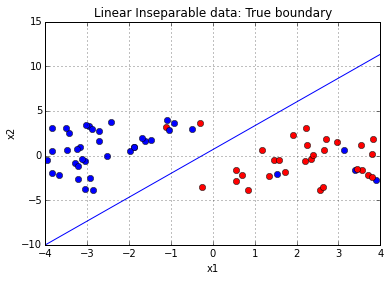

In [34]:
plot_data_boundary(data_insep, y_insep, w_insep,sep=False)

##Python-Gradient Descent

###Ridge Logistic Regression

In [37]:
np.random.seed(400)
w_gd_insep_ridge = logisticReg_GD(data_insep,y_insep,reg="Ridge")
print w_gd_insep_ridge

[ 0.88960208 -0.06413379 -0.24526051]


###Lasso Logistic Regression

In [39]:
np.random.seed(400)
w_gd_insep_lasso = logisticReg_GD(data_insep,y_insep,reg="Lasso")
print w_gd_insep_lasso

[ 0.88745901 -0.0500822  -0.14752302]


###Compsrison

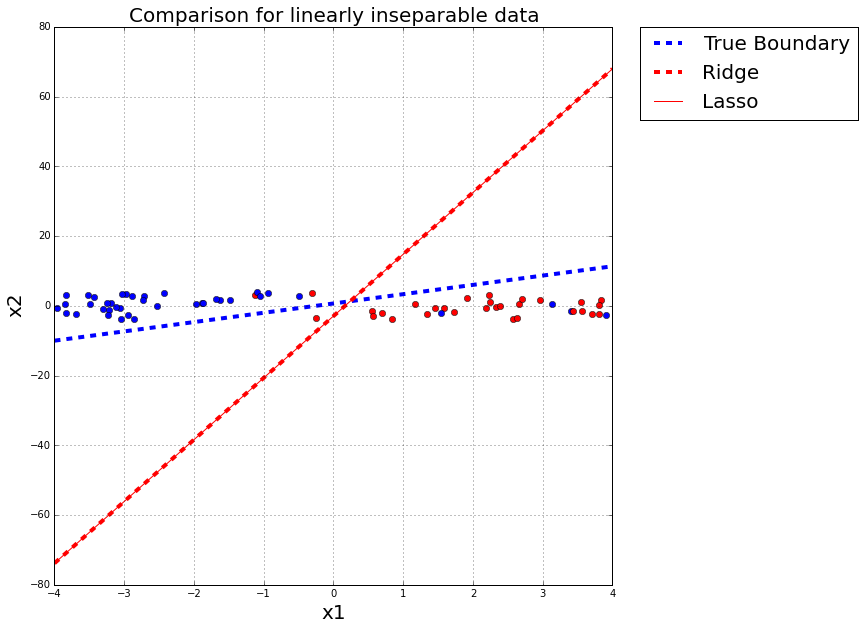

In [57]:
comparison_plot(data_insep,y_insep,w_insep,w_gd_insep_ridge,w_gd_insep_lasso,sep=False)